In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the classes and create the data loader

In [3]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in ("A", "V", "Y")]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Create the model

In [6]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = table_dnn.LabelGuidedTabularNet(
    len(classes), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/letters_continuous_AVY_labelguided"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

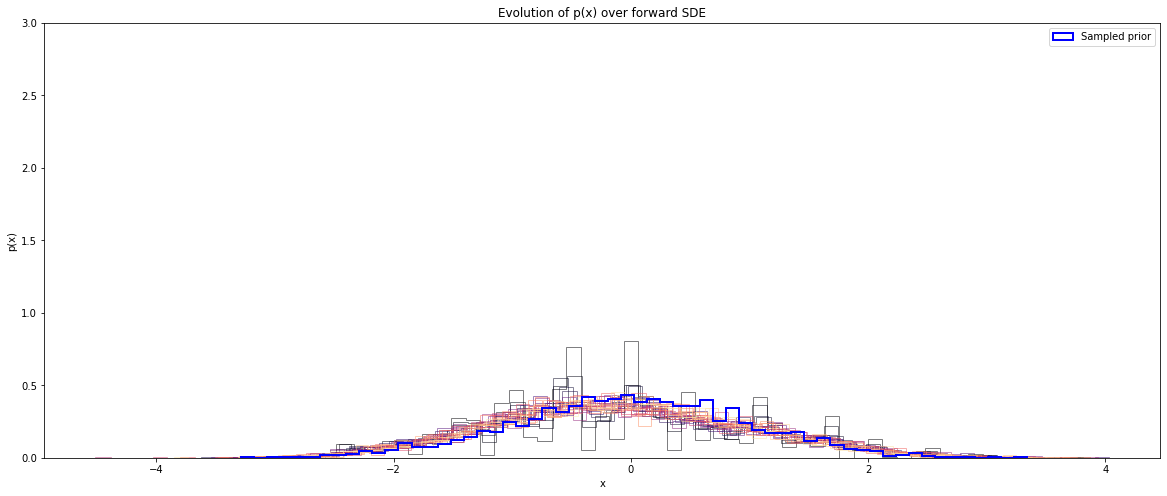

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_to_class_index": class_to_class_index_tensor,
        "num_epochs": 100,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "1"
Loss: 14.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25.06it/s]


Epoch 1 average Loss: 15.46


Loss: 11.57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.46it/s]


Epoch 2 average Loss: 13.19


Loss: 11.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.68it/s]


Epoch 3 average Loss: 11.76


Loss: 9.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.40it/s]


Epoch 4 average Loss: 10.94


Loss: 10.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.78it/s]


Epoch 5 average Loss: 10.49


Loss: 9.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.20it/s]


Epoch 6 average Loss: 10.04


Loss: 9.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.48it/s]


Epoch 7 average Loss: 9.67


Loss: 9.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.82it/s]


Epoch 8 average Loss: 9.68


Loss: 8.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.97it/s]


Epoch 9 average Loss: 9.26


Loss: 9.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.24it/s]


Epoch 10 average Loss: 9.18


Loss: 9.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.73it/s]


Epoch 11 average Loss: 9.21


Loss: 9.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.50it/s]


Epoch 12 average Loss: 9.06


Loss: 9.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.81it/s]


Epoch 13 average Loss: 8.88


Loss: 9.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.57it/s]


Epoch 14 average Loss: 8.81


Loss: 7.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.40it/s]


Epoch 15 average Loss: 8.61


Loss: 8.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.25it/s]


Epoch 16 average Loss: 8.67


Loss: 10.27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.81it/s]


Epoch 17 average Loss: 8.71


Loss: 9.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.69it/s]


Epoch 18 average Loss: 8.51


Loss: 7.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.68it/s]


Epoch 19 average Loss: 8.54


Loss: 9.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.59it/s]


Epoch 20 average Loss: 8.53


Loss: 8.37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 43.65it/s]


Epoch 21 average Loss: 8.41


Loss: 8.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 52.01it/s]


Epoch 22 average Loss: 8.40


Loss: 8.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.36it/s]


Epoch 23 average Loss: 8.26


Loss: 8.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.63it/s]


Epoch 24 average Loss: 8.19


Loss: 8.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.78it/s]


Epoch 25 average Loss: 8.27


Loss: 8.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.49it/s]


Epoch 26 average Loss: 8.14


Loss: 8.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.42it/s]


Epoch 27 average Loss: 8.18


Loss: 7.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.76it/s]


Epoch 28 average Loss: 8.08


Loss: 8.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.43it/s]


Epoch 29 average Loss: 8.14


Loss: 7.62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.00it/s]


Epoch 30 average Loss: 7.98


Loss: 8.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.00it/s]


Epoch 31 average Loss: 7.99


Loss: 7.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.87it/s]


Epoch 32 average Loss: 7.96


Loss: 7.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.81it/s]


Epoch 33 average Loss: 7.97


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.40it/s]


Epoch 34 average Loss: 8.12


Loss: 7.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.02it/s]


Epoch 35 average Loss: 7.87


Loss: 7.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.92it/s]


Epoch 36 average Loss: 7.76


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 44.77it/s]


Epoch 37 average Loss: 7.82


Loss: 8.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.87it/s]


Epoch 38 average Loss: 7.96


Loss: 7.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.76it/s]


Epoch 39 average Loss: 7.77


Loss: 7.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.75it/s]


Epoch 40 average Loss: 7.80


Loss: 8.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.11it/s]


Epoch 41 average Loss: 7.76


Loss: 8.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.45it/s]


Epoch 42 average Loss: 7.96


Loss: 8.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.71it/s]


Epoch 43 average Loss: 7.85


Loss: 8.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.36it/s]


Epoch 44 average Loss: 7.62


Loss: 8.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.70it/s]


Epoch 45 average Loss: 7.72


Loss: 8.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.56it/s]


Epoch 46 average Loss: 7.77


Loss: 7.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.57it/s]


Epoch 47 average Loss: 7.55


Loss: 8.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.43it/s]


Epoch 48 average Loss: 7.79


Loss: 7.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.75it/s]


Epoch 49 average Loss: 7.78


Loss: 6.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.59it/s]


Epoch 50 average Loss: 7.62


Loss: 8.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch 51 average Loss: 7.75


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.59it/s]


Epoch 52 average Loss: 7.66


Loss: 5.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.65it/s]


Epoch 53 average Loss: 7.47


Loss: 7.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.61it/s]


Epoch 54 average Loss: 7.48


Loss: 7.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.81it/s]


Epoch 55 average Loss: 7.75


Loss: 7.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.61it/s]


Epoch 56 average Loss: 7.61


Loss: 8.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.15it/s]


Epoch 57 average Loss: 7.53


Loss: 7.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.98it/s]


Epoch 58 average Loss: 7.39


Loss: 6.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.94it/s]


Epoch 59 average Loss: 7.40


Loss: 8.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.21it/s]


Epoch 60 average Loss: 7.59


Loss: 7.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.60it/s]


Epoch 61 average Loss: 7.52


Loss: 8.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.58it/s]


Epoch 62 average Loss: 7.64


Loss: 8.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.40it/s]


Epoch 63 average Loss: 7.62


Loss: 8.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.49it/s]


Epoch 64 average Loss: 7.50


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.72it/s]


Epoch 65 average Loss: 7.59


Loss: 7.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 38.90it/s]


Epoch 66 average Loss: 7.55


Loss: 8.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.48it/s]


Epoch 67 average Loss: 7.64


Loss: 7.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.36it/s]


Epoch 68 average Loss: 7.39


Loss: 8.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.33it/s]


Epoch 69 average Loss: 7.52


Loss: 8.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.39it/s]


Epoch 70 average Loss: 7.47


Loss: 7.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.01it/s]


Epoch 71 average Loss: 7.43


Loss: 7.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.28it/s]


Epoch 72 average Loss: 7.49


Loss: 9.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.80it/s]


Epoch 73 average Loss: 7.56


Loss: 7.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 44.11it/s]


Epoch 74 average Loss: 7.37


Loss: 7.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.22it/s]


Epoch 75 average Loss: 7.29


Loss: 8.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.65it/s]


Epoch 76 average Loss: 7.60


Loss: 6.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 27.88it/s]


Epoch 77 average Loss: 7.21


Loss: 7.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.11it/s]


Epoch 78 average Loss: 7.26


Loss: 6.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.80it/s]


Epoch 79 average Loss: 7.33


Loss: 7.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.06it/s]


Epoch 80 average Loss: 7.28


Loss: 7.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.89it/s]


Epoch 81 average Loss: 7.27


Loss: 6.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.26it/s]


Epoch 82 average Loss: 7.13


Loss: 6.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.09it/s]


Epoch 83 average Loss: 7.28


Loss: 7.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.33it/s]


Epoch 84 average Loss: 7.43


Loss: 7.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.74it/s]


Epoch 85 average Loss: 7.34


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.36it/s]


Epoch 86 average Loss: 7.39


Loss: 8.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.67it/s]


Epoch 87 average Loss: 7.39


Loss: 6.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 43.57it/s]


Epoch 88 average Loss: 7.16


Loss: 7.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 48.52it/s]


Epoch 89 average Loss: 7.24


Loss: 7.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.26it/s]


Epoch 90 average Loss: 7.40


Loss: 7.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.90it/s]


Epoch 91 average Loss: 7.35


Loss: 7.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.03it/s]


Epoch 92 average Loss: 7.22


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 38.44it/s]


Epoch 93 average Loss: 7.27


Loss: 7.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.91it/s]


Epoch 94 average Loss: 7.13


Loss: 9.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.27it/s]


Epoch 95 average Loss: 7.36


Loss: 7.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.54it/s]


Epoch 96 average Loss: 7.15


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.59it/s]


Epoch 97 average Loss: 7.19


Loss: 6.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.24it/s]


Epoch 98 average Loss: 7.16


Loss: 7.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46.36it/s]


Epoch 99 average Loss: 7.20


Loss: 7.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 47.68it/s]
INFO - train - Completed after 0:00:43


Epoch 100 average Loss: 7.31
